# View atmospheric profile ratio to that of a standard atmosphere

- author  :Sylvie Dagoret-Campagne
- affiliaiton : IJCLab/IN2P3/CNRS
- creation date : April 24th 2020
- update date :


Study the relative atmosphere relative to an ideal profile in **libradtran/info_verbose/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT**
- no aerosol
- pwv =4 mm
- ozone = 3000 DU
- No extinction coefficient
- airmass = 1



Last Verification : December 14th 2021


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import pandas as pd
import os
import sys
import re
%matplotlib inline

In [2]:
from astropy.io import fits

In [3]:
from datetime import datetime,date
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [4]:
#to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [5]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

In [6]:
%load_ext autoreload
%autoreload 2

# Configuration

## Filter boudaries

In [7]:
file_wavelengthbins="data/WaveLengthBins.csv"

In [8]:
df=pd.read_csv(file_wavelengthbins,index_col=0)

In [9]:
df

,band,wl_aver,wl_wdth,wl_min,wl_max
0,u,356.0,78.0,317.0,395.0
1,g,472.0,154.0,395.0,549.0
2,r,619.0,140.0,549.0,689.0
3,i,754.0,130.0,689.0,819.0
4,z,870.5,103.0,819.0,922.0
5,y,1010.0,176.0,922.0,1098.0


In [10]:
NBFILTER=len(df)

In [11]:
FILTER_NAME=df["band"].values
WL_MIN=df["wl_min"].values
WL_MAX=df["wl_max"].values

## Atmospheric data

In [12]:
DATADIR="../data/atm"

## Reference atmosphere

In [13]:
data=np.loadtxt("data/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT")
wl0=data[:,0]
transm0=data[:,1]

In [14]:
def GetAtmosphericProfiles(dir,wl_ref,transm_ref):
    """
    """
    atmospheric_basename_files=os.listdir(dir)
    inputfile=os.path.join(DATADIR,atmospheric_basename_files[0])
    
    idx=0
    # containers
    all_data=[]
    all_hdr=[]
    all_wl=[]
    
    # loop on files
    for file in atmospheric_basename_files:
        if re.search("^lsst_atm_10year_[0-9][0-9].*fits$",file):
            inputfile=os.path.join(DATADIR,file)
            hdu = fits.open(inputfile)
            all_hdr.append(hdu[0].header)
            all_data.append(hdu[0].data[1:,:])
            all_wl.append(hdu[0].data[0,:])
            idx+=1
            hdu.close()
        
    data=np.vstack(all_data)
    hdr=all_hdr[0]
    
    #decode index from header
    NbAtmSimul=hdr['NBATMSIM']
    idx_out_num=hdr['ID_NUM']
    idx_out_year=hdr['ID_YEAR']
    idx_out_am=hdr['ID_AM']
    idx_out_vaod=hdr['ID_VAOD']
    idx_out_pwv=hdr['ID_PWV']
    idx_out_o3=hdr['ID_O3']
    idx_out_cld=hdr['ID_CLD']
    idx_out_res=hdr['ID_RES']
    
    vaod=data[1:,idx_out_vaod] # vertical aerosol depth
    pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
    o3=data[1:,idx_out_o3]     # ozone
    cld=data[1:,idx_out_cld]   # clouds (not used)
    
    
    # Extract wavelength Wavelength
    wl=all_wl[0][idx_out_res:]
    transm=data[:,idx_out_res:]
    
    if len(wl)==len(wl_ref) and wl[0]== wl_ref[0]:
        transm/=transm_ref
    else:
        print("error reference does not match")
        
    
    return wl,transm,vaod,pwv,o3,cld
     

# Open all atmospheric files

In [15]:
wl,transm,vaod,pwv,o3,cld=GetAtmosphericProfiles(DATADIR,wl0,transm0)

/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_9174/3630337460.py:49: RuntimeWarning: divide by zero encountered in true_divide
  transm/=transm_ref
/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_9174/3630337460.py:49: RuntimeWarning: invalid value encountered in true_divide
  transm/=transm_ref


In [16]:
NBSIM=transm.shape[0]
# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSIM)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSIM), alpha=1)

# Distribute the relative transmission in the different filters

In [17]:
all_wl_filt=[]
all_transm_filt=[]
for iband in np.arange(NBFILTER):
    wl_indexes=np.where(np.logical_and(wl>=WL_MIN[iband],wl<=WL_MAX[iband]))[0]
    wl_filt=wl[wl_indexes]
    transm_filt=transm[:,wl_indexes]
    all_wl_filt.append(wl_filt)
    all_transm_filt.append(transm_filt)
    

# Plot

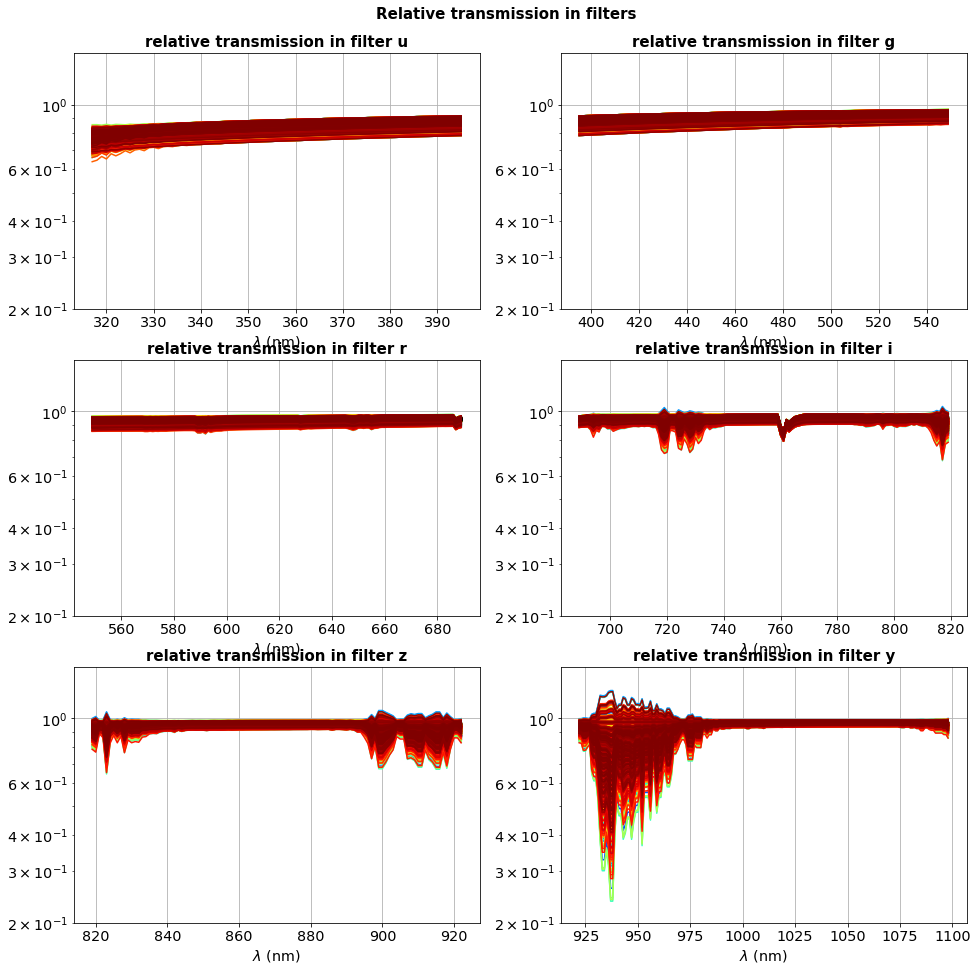

In [18]:
plt.figure(figsize=(16,16))
# loop on filter
for iband in np.arange(NBFILTER):
    wl=all_wl_filt[iband]
    transm=all_transm_filt[iband] 
    
    plt.subplot(3,2,iband+1)  
    # loop on simulation
    for idx in np.arange(NBSIM):
        colorVal=scalarMap.to_rgba(idx, alpha=1)
        plt.plot(wl,transm[idx,:],color=colorVal)
    plt.grid(True)
    plt.ylim(0.2,1.5)
    plt.yscale("log")
    plt.xlabel("$\lambda$ (nm)")
    title="relative transmission in filter {}".format(FILTER_NAME[iband])
    plt.title(title,fontweight="bold",fontsize=15)
plt.suptitle("Relative transmission in filters",fontweight="bold",fontsize=15,y=0.92)
figname=string_date+"_RelativeTransmissionFilters.png"
plt.savefig(figname)
plt.show()  